In [13]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from IPython.display import clear_output

## Introduction

This notebook demos how to estimate blood pressure from PPG waveforms using a convolutional neural network (CNN) with Long Short Term Memory (LSTM) layers. CNN models are typically used in vision applications to recogize shapes and patterns, and LSTM layers can help identify temporal dependencies in those patterns.

PPG signals are 1-dimensional over time, so 1D convoutions are used, and we incorporate the 1st-3rd derivatives of PPG signals, for a total of 4x 1-dimensional channels as input. The CNN essentially fits an encoding to the PPG data, which helps identify the most useful patterns needed to estimate blood pressure. That encoding is fed into the LSTM layers, and then a fully connected layer for the final blood pressure prediction. In practice we could have the fully connected layer output both systolic and diastilic blood pressure values, but for now it's just outputting systolic.

Similar CNN+LSTM architecture has been described in literature. The featured image for this post shows a the model diagram from the paper:

Y. A. M. Alsumaidaee et al., "Fault Detection for Medium Voltage Switchgear Using a Deep Learning Hybrid 1D-CNN-LSTM Model," in IEEE Access, vol. 11, pp. 97574-97589, 2023, doi: 10.1109/ACCESS.2023.3294093.

Code and data can be found in the [PPG_to_BP repository](https://github.com/jnaramore/PPG_to_BP).

## Data preparation

The raw PPGBP dataset was preprocessed with steps including (1) bandpass filter, (2) 1st-3rd derivative calculation and (3) pulse segmentation in the notebook `PPG_to_BP_preprocessing.ipynb`. From there, is was saved as a .mat file, which is loaded below.

In [6]:
mat_data = sio.loadmat('ppg_signals.mat')
subj_ids = [mat_data['id'][i].strip().split('_')[0] for i in range(len(mat_data['id']))]
print(f"Preprocessed PPGBP dataset includes {len(subj_ids)} pulses from {len(np.unique(subj_ids))} different subjects")

Preprocessed PPGBP dataset includes 1264 pulses from 219 different subjects


Let's plot a sample PPG signal with it's first derivative:

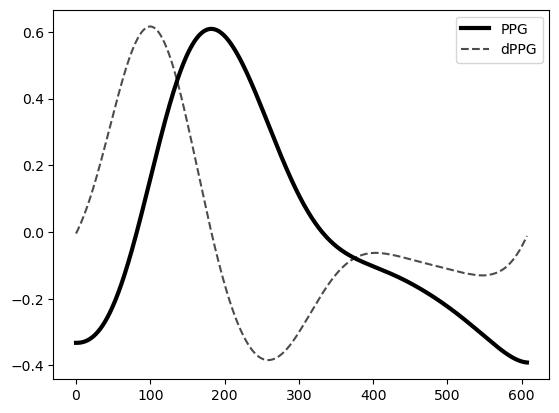

In [44]:
idx = 0

ppg = mat_data['ppg'][0][0][0]
vpg = mat_data['vpg'][0][0][0]

ppg_scale = np.max(ppg) - np.min(ppg)
plt.plot(ppg/ppg_scale,label='PPG',color='black',linewidth=3)
vpg_scale = np.max(vpg) - np.min(vpg)
plt.plot(vpg/vpg_scale,linestyle='--',color='black',alpha=.7,label="dPPG")
plt.legend()
plt.show()


Dataset class and collate function are needed to for the PyTorch DataLoader. Since the pulses are of variable lengths, the collate function helps build a padded tensor.

In [8]:
#Load data into lists
ppg_list = [mat_data['ppg'][0][i][0] for i in range(mat_data['ppg'].shape[1])]
ppg_derivs_list = []
for i in range(mat_data['ppg'].shape[1]):
    ppg = mat_data['ppg'][0][i][0]
    vpg = mat_data['vpg'][0][i][0]
    apg = mat_data['apg'][0][i][0]
    jpg = mat_data['jpg'][0][i][0]
    ppg_derivs_list.append(np.stack([ppg, vpg, apg, jpg], axis=0))  # shape (4,L)

sbp_list = [mat_data['sbp'][0][i] for i in range(mat_data['sbp'].shape[1])]

# ---------------------------
# Dataset
# ---------------------------
class PulseDatasetDerivs(Dataset):
    def __init__(self, signals: list[np.ndarray], targets: list[float], transform=None):
        assert len(signals) == len(targets)
        self.signals = signals
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.signals)

    def __getitem__(self, idx):
        x = self.signals[idx].astype(np.float32)  # shape: (4,T)
        y = np.float32(self.targets[idx])
        if self.transform is not None:
            x = self.transform(x)
        return x, y
    
# ---------------------------
# collate fn: pad and return lengths
# ---------------------------
def collate_pad_channels(batch, pad_value=0.0):
    # batch: list of (stacked (C,L), y)
    signals, targets = zip(*batch)
    lengths = [s.shape[1] for s in signals]  # L per example
    max_len = max(lengths)
    batch_size = len(signals)
    channels = signals[0].shape[0]  # expect consistent channels
    padded = np.full((batch_size, channels, max_len), pad_value, dtype=np.float32)
    for i, s in enumerate(signals):
        L = s.shape[1]
        padded[i, :, :L] = s
    return torch.from_numpy(padded), torch.tensor(lengths, dtype=torch.long), torch.tensor(targets, dtype=torch.float32)


## Train-test split by subject

The train-test split is done by subject ID, since there are multiple pulses in the data from the same subject, some of which are sequential. Therefore it would be possible that for 2 pulses in sequence, the first could be in the training set and the 2nd could be in the test set (if we did not split by subject ID).

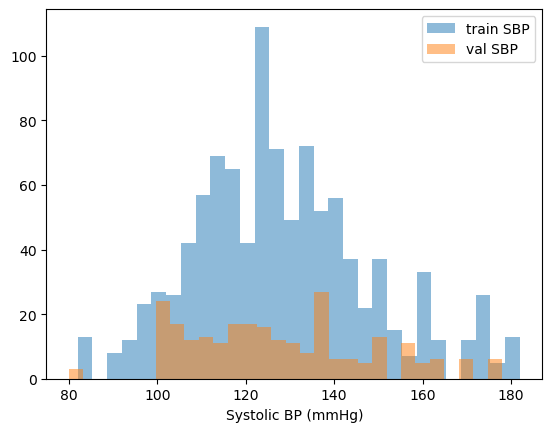

In [46]:
rng = np.random.RandomState(2)

# train test split by subject IDs
unique_ids = np.unique(subj_ids)
train_idxs = rng.choice(len(unique_ids), size=int(0.8*len(unique_ids)), replace=False)

train_ppg = [ppg_list[i] for i in range(len(ppg_list)) if subj_ids[i] in unique_ids[train_idxs]]
train_ppg_derivs = [ppg_derivs_list[i] for i in range(len(ppg_list)) if subj_ids[i] in unique_ids[train_idxs]]
train_sbp = [sbp_list[i] for i in range(len(sbp_list)) if subj_ids[i] in unique_ids[train_idxs]]

val_ppg = [ppg_list[i] for i in range(len(ppg_list)) if subj_ids[i] not in unique_ids[train_idxs]]
val_ppg_derivs = [ppg_derivs_list[i] for i in range(len(ppg_list)) if subj_ids[i] not in unique_ids[train_idxs]]
val_sbp = [sbp_list[i] for i in range(len(sbp_list)) if subj_ids[i] not in unique_ids[train_idxs]]

plt.hist(train_sbp, bins=30, alpha=0.5, label='train SBP')
plt.hist(val_sbp, bins=30, alpha=0.5, label='val SBP')
plt.xlabel('Systolic BP (mmHg)')
plt.legend()
plt.show()

## Define CNN+LSTM model

The CNN+LSTM model is defined below using PyTorch, which includes a CNN encoding layer followed by LSTM layers, and a fully-connected regression head:

1. **CNN Encoding**: Each CNN layer includes a 1-dimensional convolution -> batch norm -> ReLU activation -> max pooling -> dropout. The is max pooling is optional, and serves to downsample the inputs for the deeper layers by a factor of 2.  

2. **LSTM**: Next, LSTM layers help to account for temporal dependencies for CNN features. Bidirectional LSTM is used by default.

3. **Fully-connected head**: This has 2 fully connected linear layers that take in the LSTM output and predict a single blood pressure value. 

In [10]:
class CNN_LSTM_Regressor(nn.Module):
    def __init__(
        self, 
        in_channels=1, 
        channels=[32,64,128], 
        kernel_size=[7,7,7], 
        dropout=0.2, 
        use_maxpool=True,
        lstm_hidden=128,
        lstm_layers=1,
        bidirectional=True
    ):
        super().__init__()
        # --------------- CNN Encoder ----------------
        layers = []
        prev = in_channels
        self.downsample = 1

        for ch, kern in zip(channels, kernel_size):
            layers.append(nn.Conv1d(prev, ch, kernel_size=kern, padding=(kern-1)//2))
            layers.append(nn.BatchNorm1d(ch))
            layers.append(nn.ReLU(inplace=True))
            if use_maxpool:
                layers.append(nn.MaxPool1d(kernel_size=2, stride=2))
                self.downsample *= 2
            layers.append(nn.Dropout(dropout))
            prev = ch

        self.encoder = nn.Sequential(*layers)

        # --------------- LSTM ----------------
        self.bidir = bidirectional
        lstm_input_size = prev  # last CNN channel count
        self.lstm = nn.LSTM(
            input_size=lstm_input_size,
            hidden_size=lstm_hidden,
            num_layers=lstm_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=0.1 if lstm_layers > 1 else 0
        )

        # --------------- Final FC ----------------
        lstm_out_dim = lstm_hidden * (2 if bidirectional else 1)
        self.fc = nn.Sequential(
            nn.Linear(lstm_out_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1)
        )


    def forward(self, x, lengths):
        # x: (B, 1, L)
        B = x.size(0)

        # 1) CNN
        out = self.encoder(x)   # (B, C, L')
        C = out.size(1)
        Lp = out.size(2)        # <-- TRUE output sequence length

        # 2) Force downsampled lengths = true CNN output length
        lengths_down = torch.full((B,), Lp, dtype=torch.long, device=x.device)

        # 3) Rearrange for LSTM: (B, L', C)
        seq = out.permute(0, 2, 1)

        # 4) Pack with CORRECT lengths
        packed = nn.utils.rnn.pack_padded_sequence(
            seq,
            lengths_down.cpu(),
            batch_first=True,
            enforce_sorted=False
        )

        # 5) LSTM forward
        packed_out, (h_n, c_n) = self.lstm(packed)

        # 6) Extract last hidden state
        if self.bidir:
            h_last = torch.cat([h_n[-2], h_n[-1]], dim=1)
        else:
            h_last = h_n[-1]

        # 7) Regression head
        return self.fc(h_last).squeeze(1)

## Training

Training and evaluation functions are defined below. I prefer to use mean absolute error (MAE) for comparison to other research papers

$$ \text{MAE} = \frac{1}{n} \sum_{i=1}^n | y_i - \hat{y} |$$

In [37]:
# ---------------------------
# Training loop skeleton
# ---------------------------
def train_epoch(model, dataloader, optimizer, device):
    model.train()
    total_loss = 0.0
    for x, lengths, y in dataloader:
        x = x.to(device)
        lengths = lengths.to(device)
        y = y.to(device)
        preds = model(x, lengths)
        loss = F.mse_loss(preds, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x.size(0)
    return total_loss / len(dataloader.dataset)

def eval_epoch(model, dataloader, device):
    model.eval()
    total_loss = 0.0
    preds_all, y_all = [], []
    with torch.no_grad():
        for x, lengths, y in dataloader:
            x = x.to(device); lengths = lengths.to(device); y = y.to(device)
            preds = model(x, lengths)
            loss = F.mse_loss(preds, y)
            total_loss += loss.item() * x.size(0)
            preds_all.append(preds.cpu().numpy())
            y_all.append(y.cpu().numpy())
    preds_all = np.concatenate(preds_all)
    y_all = np.concatenate(y_all)
    mae = np.mean(np.abs(preds_all - y_all))
    rmse = np.sqrt(np.mean((preds_all - y_all)**2))
    return total_loss / len(dataloader.dataset), mae, rmse

# I prefer to use GPU, if possible:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Device available for running: ", device)

Device available for running:  mps


Finally here's the training loop. I've found the parameters below to work well, which includes 4 CNN layers and 2 LSTM layers. The CNN kernel size is set to 60, 

Epoch 100 train_MAE=10.5654 test_MAE=12.8249


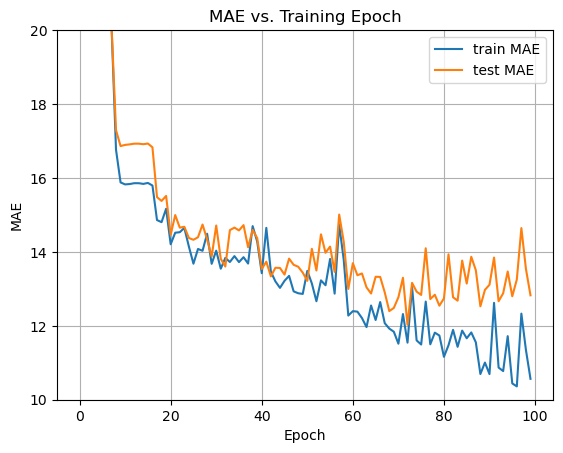

In [45]:
#create dataloaders
ds_train = PulseDatasetDerivs(train_ppg_derivs, train_sbp)
ds_test = PulseDatasetDerivs(val_ppg_derivs, val_sbp)
dl_train = DataLoader(ds_train, batch_size=32, shuffle=True, collate_fn=collate_pad_channels, num_workers=0)
dl_test = DataLoader(ds_test, batch_size=32, shuffle=True, collate_fn=collate_pad_channels, num_workers=0)

model = CNN_LSTM_Regressor(in_channels=4,
                     channels=[16,32,64,128], 
                     kernel_size=[240,120,60,60],
                     dropout=0.2,
                     lstm_hidden=16,
                     lstm_layers=2
                     ).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

mae_train_list = []
mae_test_list = []
for epoch in range(1, 101):
    tr_loss = train_epoch(model, dl_train, optimizer, device)
    val_loss_train, mae_train, rmse_train = eval_epoch(model, dl_train, device)
    mae_train_list.append(mae_train)
    val_loss_test, mae_test, rmse_test = eval_epoch(model, dl_test, device)
    mae_test_list.append(mae_test)

    #Update plot and printed output
    clear_output(wait=True)
    print(f"Epoch {epoch:02d} train_MAE={mae_train:.4f} test_MAE={mae_test:.4f}")
    fig, ax = plt.subplots()
    ax.plot(mae_train_list, label='train MAE')
    ax.plot(mae_test_list, label='test MAE')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('MAE')
    # plt.yscale('log')
    if epoch > 20:
        ax.set_ylim(10,20)
    ax.legend()
    ax.grid()
    ax.set_title("MAE vs. Training Epoch")
    display(fig)
    plt.close(fig)


## Conclusions

The best test MAE is observed to be about 12.5 mmHg at ~70 epochs, and then we can see overfitting separation between the train and test MAE after that. Test MAE is very dependent on the train-test split due to the relatively small data size, but an MAE of 12.5 mmHg comparable to those found in the benchmark paper from Gonzalez as well as my recent blog post using XGBoost.

The basic framework for a CNN+LSTM blood pressure prediction model is shown here. This accuracy might be as good as it gets with the PPGBP dataset due to it's small size, and limited data points at lower and higher blood pressure values. A next step is to further explore other datasets and papers like Paviglianiti's, which appears to have a much larger dataset and suggests a Resnet-LSTM architecture.

## References

Y. A. M. Alsumaidaee et al., "Fault Detection for Medium Voltage Switchgear Using a Deep Learning Hybrid 1D-CNN-LSTM Model," in IEEE Access, vol. 11, pp. 97574-97589, 2023, doi: 10.1109/ACCESS.2023.3294093.

González, Sergio, Wan-Ting Hsieh, and Trista Pei-Chun Chen. "A benchmark for machine-learning based non-invasive blood pressure estimation using photoplethysmogram." Scientific Data 10, no. 1 (2023): 149.

Paviglianiti A, Randazzo V, Villata S, Cirrincione G, Pasero E. A Comparison of Deep Learning Techniques for Arterial Blood Pressure Prediction. Cognit Comput. 2022;14(5):1689-1710. doi: 10.1007/s12559-021-09910-0. Epub 2021 Aug 27. PMID: 34466163; PMCID: PMC8391010.